In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.utils.data

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
     # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

def load_dataset(train: bool) -> torch.utils.data.Dataset:
    return torchvision.datasets.CIFAR10(root='./data', train=train, transform=transform)

def create_data_loader(dataset: torch.utils.data.Dataset, batch_size: int, num_workers: int, shuffle: bool) -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=shuffle, 
        num_workers=num_workers,
    )

In [3]:
BATCH_SIZE = 16
NUM_WORKERS = 4

train_dataset = load_dataset(train=True)
test_dataset = load_dataset(train=False)
train_dataset, val_dataset = torch.utils.data.dataset.random_split(train_dataset, [0.8, 0.2])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
train_data_loader = create_data_loader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_data_loader = create_data_loader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_data_loader = create_data_loader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [5]:
train_iter = iter(train_data_loader)

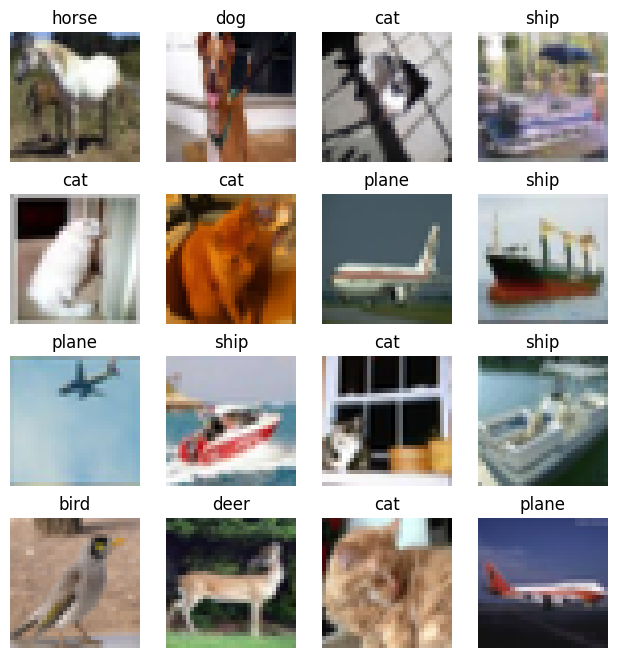

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


def plot_image_grid(image_batch: torch.tensor, batch_classes: torch.tensor, img_per_row: int = 4):
    no_of_rows = BATCH_SIZE // img_per_row
    plt.figure(figsize = (no_of_rows * 2, img_per_row * 2))
    gs = gridspec.GridSpec(no_of_rows, img_per_row)
    gs.update(wspace=0.025, hspace=0.25)
    
    for i in range(no_of_rows):
        for j in range(img_per_row):
            idx = i*no_of_rows + j
            ax = plt.subplot(gs[idx])
            img = image_batch[idx]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            ax.set_title(classes[batch_classes[idx]])
            ax.axis('off')
            ax.imshow(img.permute(1, 2, 0))
            
    plt.show()

batch, y_hat = next(train_iter)
plot_image_grid(batch, y_hat)

In [76]:
import torch.nn as nn

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(6, 16, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Flatten(),
            nn.Linear(400, 128),
            nn.Linear(128, 10)
        )
        
    def forward(self, example):
        return self.model(example)

net = Net()

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [78]:
print(device)
net = net.to(device)

cuda


In [79]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [80]:
for epoch in range(10):  # loop over the dataset multiple times
    i = 0
    running_loss = 0.0
    print(f"Epoch {epoch}")
    for inputs, labels in train_data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        i += 1
        if i % 1000 == 0:  
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0

print('Finished Training')

Epoch 0
[1,  1001] loss: 2.193
[1,  2001] loss: 1.933
Epoch 1
[2,  1001] loss: 1.701
[2,  2001] loss: 1.622
Epoch 2
[3,  1001] loss: 1.524
[3,  2001] loss: 1.494
Epoch 3
[4,  1001] loss: 1.445
[4,  2001] loss: 1.416
Epoch 4
[5,  1001] loss: 1.395
[5,  2001] loss: 1.374
Epoch 5
[6,  1001] loss: 1.331
[6,  2001] loss: 1.347
Epoch 6
[7,  1001] loss: 1.300
[7,  2001] loss: 1.307
Epoch 7
[8,  1001] loss: 1.268
[8,  2001] loss: 1.269
Epoch 8
[9,  1001] loss: 1.231
[9,  2001] loss: 1.250
Epoch 9
[10,  1001] loss: 1.229
[10,  2001] loss: 1.187
Finished Training


In [81]:
correct = 0
total = 0

net = net.to('cpu')
with torch.no_grad():
    for images, labels in test_data_loader:
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        correct += (labels == predictions).sum()
        total += len(labels)

print(f'Accuracy {(100* correct / total):.2f} %')

Accuracy 55.57 %
